# Curves

**Curves are one of the fundamental objects in `welly`.**

`Well` objects include collections of `Curve` objects. Multiple `Well` objects can be stored in a `Project`.

On this page, we take a closer look at the `Curve` object.


Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.4.10.dev55+g212e99f.d20220214'

## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [2]:
from welly import Well

p129 = Well.from_las('https://geocomp.s3.amazonaws.com/data/P-129.LAS')

Only engine='normal' can read wrapped files


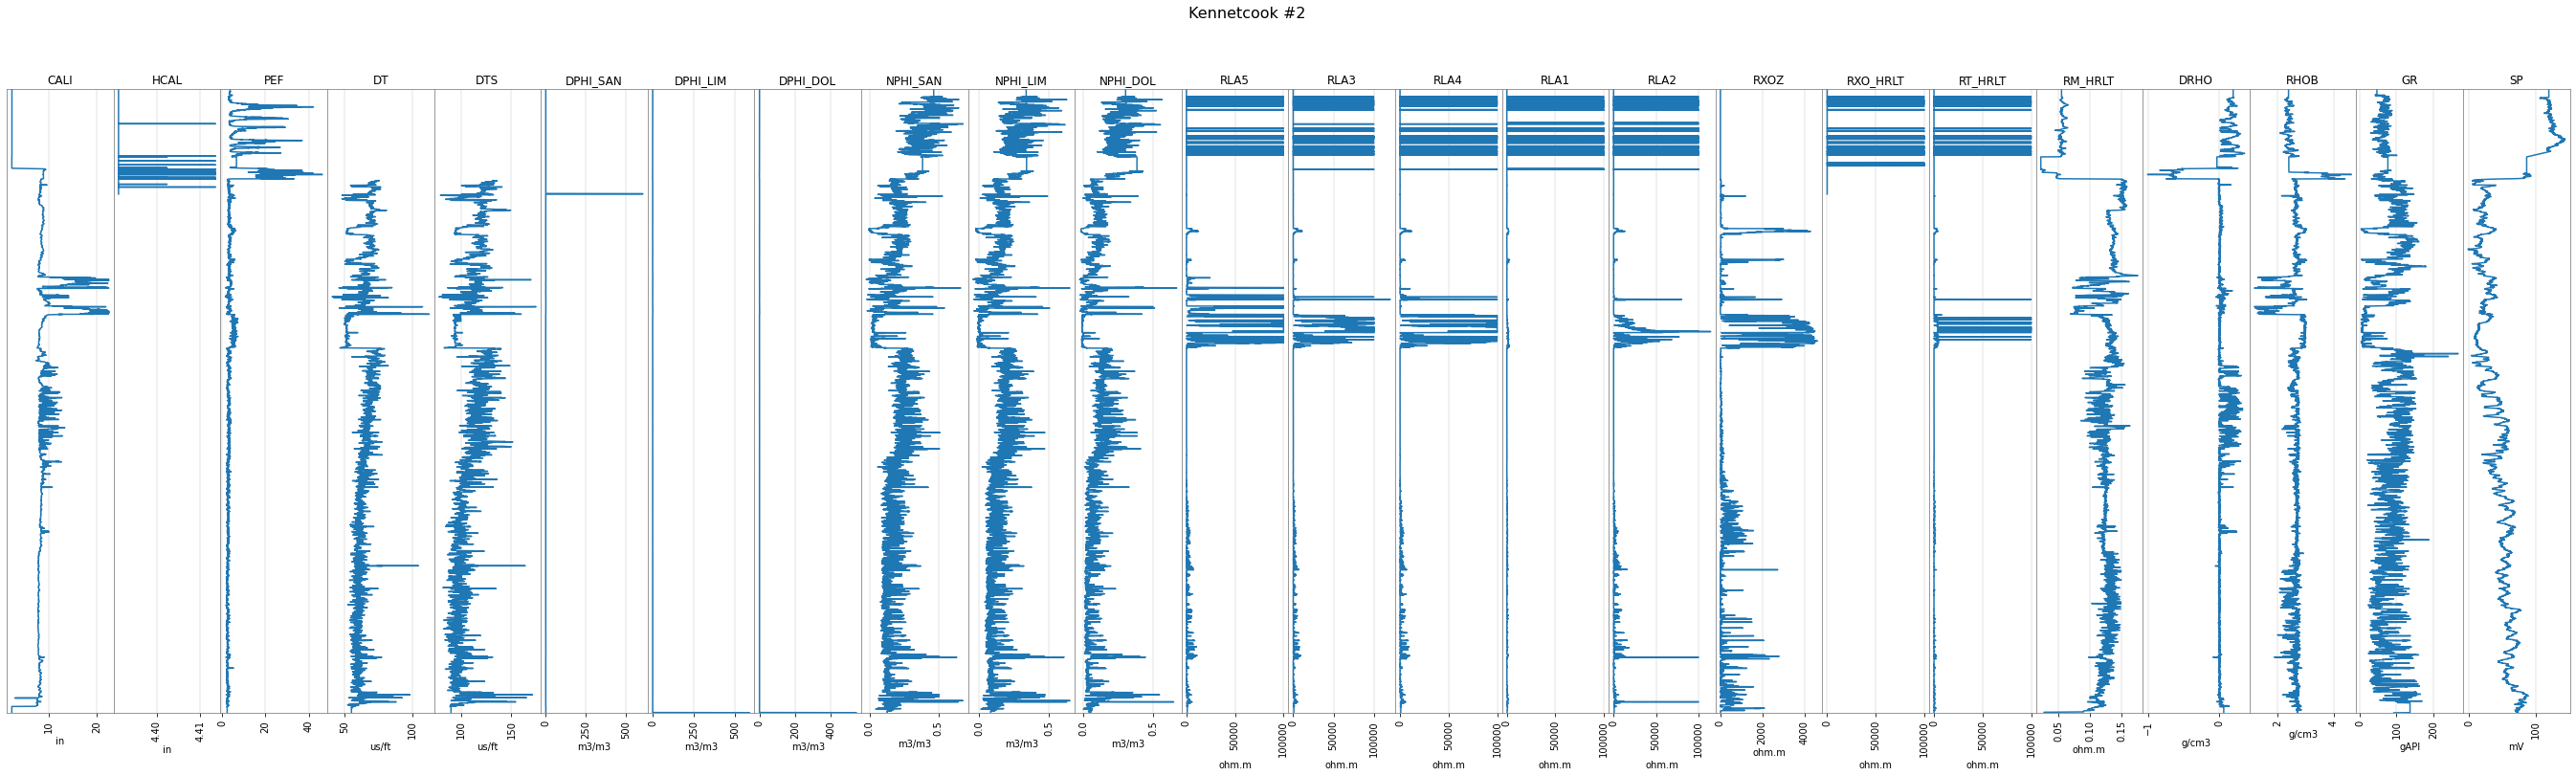

In [3]:
p129.plot()

The curves are stored in the `data` attribute, which is an ordinary dictionary:

In [4]:
p129.data

{'CALI': Curve(mnemonic=CALI, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'HCAL': Curve(mnemonic=HCAL, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[2139]),
 'PEF': Curve(mnemonic=PEF, units=, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'DT': Curve(mnemonic=DT, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10850]),
 'DTS': Curve(mnemonic=DTS, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10850]),
 'DPHI_SAN': Curve(mnemonic=DPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'DPHI_LIM': Curve(mnemonic=DPHI_LIM, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'DPHI_DOL': Curve(mnemonic=DPHI_DOL, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'NPHI_SAN': Curve(mnemonic=NPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12718]),
 'NPHI_LIM': Curve(mnemonic=NPHI_LIM, units=m3/m3, start=1.0668, stop=

Let's look at one log:

In [5]:
gr = p129.data['GR']

gr

Curve(mnemonic=GR, units=gAPI, start=1.0668, stop=1939.1376, step=0.1524, count=[12718])

The object knows some things about itself:

In [28]:
gr.mnemonic, gr.units, gr.start, gr.stop, gr.step

('GR', 'gAPI', 1.0668, 1939.1376, 0.1524000000000001)

Curves have various methods on them, such as `plot()`...

<AxesSubplot:title={'center':'GR'}, xlabel='gAPI'>

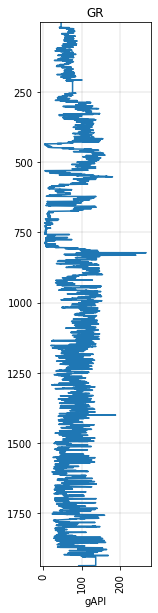

In [6]:
gr.plot()

Often we just want to look at or deal with a portion of the curve, or maybe resample it:

<AxesSubplot:title={'center':'GR'}, xlabel='gAPI'>

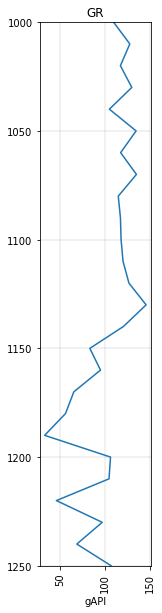

In [11]:
gr.to_basis(start=1000, stop=1250, step=10.0).plot()

## Interpolation and slicing

We can read the curve at any depth (or depths) and get an interpolated reading:

In [16]:
gr.read_at([1200, 1300, 1400])

[105.9837716184255, 103.79578067107755, 96.33845173590835]

There are no samples at those depths; the well is sampled at a 0.1524 m interval:

In [17]:
gr.step

0.1524000000000001

The actual depths of the samples are in the 'index':

In [19]:
gr.index

Float64Index([   1.0668,    1.2192,    1.3716,     1.524,    1.6764,    1.8288,
                 1.9812,    2.1336,     2.286,    2.4384,
              ...
               1937.766, 1937.9184, 1938.0708, 1938.2232, 1938.3756,  1938.528,
              1938.6804, 1938.8328, 1938.9852, 1939.1376],
             dtype='float64', name='DEPT', length=12718)

You can slice a curve by this index; in other words, **by depth**:

In [20]:
gr[1000:1010]

Curve(mnemonic=GR, units=gAPI, start=1000.0488, stop=1009.9548, step=0.1524, count=[66])

You can get a statistical description of a curve:

In [23]:
gr.describe()  # Equivalent to get_stats()

,GR
count,12718.0000000000
mean,78.9863535888
std,37.0719153332
min,3.8940699100
25%,51.3325605393
50%,76.5569686890
75%,109.8330020900
max,267.9404296900


## Mathematics

In [26]:
gr.mean()

GR    78.9863535888
dtype: float64

Mathematical operations results in another Curve object, but the values are transformed:

In [31]:
1000 * p129.data['RHOB']

Curve(mnemonic=RHOB, units=g/cm3, start=1.0668, stop=1939.1376, step=0.1524, count=[12707])

**Beware, for the time being, units are not transformed by mathematical operations!**

## Plotting

<AxesSubplot:title={'center':'GR'}, xlabel='gAPI'>

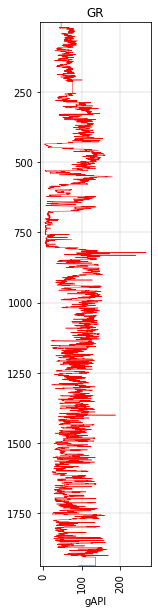

In [33]:
gr.plot(c='r', lw=0.5)

There's also a pseudocolor 2D ribbon plot:

<AxesSubplot:>

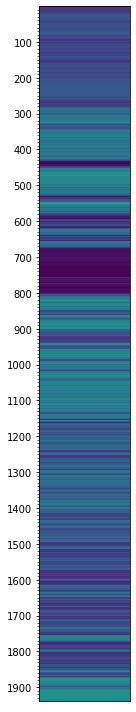

In [34]:
gr.plot_2d()

You can optionally show the curve trace as well with `curve=True`:

(0.0, 200.0)

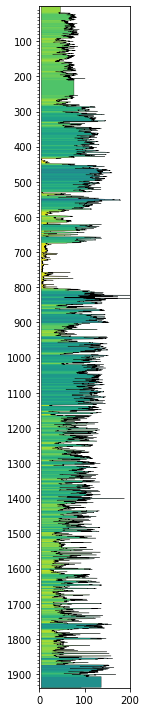

In [35]:
gr.plot_2d(cmap='viridis_r', curve=True, lw=0.3, edgecolor='k')
plt.xlim(0,200)

## Despike

You can despike with a window length for the trend and a Z-score to clip at — the curve is compared to the median *in the window* using the standard deviation *from the entire curve*. Here's the difference:

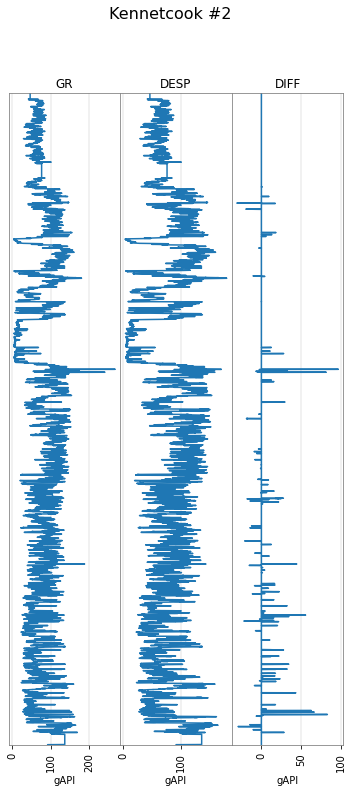

In [38]:
p129.data['DESP'] = gr.despike(z=1)
p129.data['DIFF'] = gr - p129.data['DESP']
p129.plot(tracks=['GR', 'DESP', 'DIFF'])

## Blocking

We can block a curve. Let's look at a small segment:

In [39]:
segment = gr.to_basis(start=600, stop=680)

We can create a binary log (0's and 1's) with a simple cutoff:

Text(0.5, 0, '')

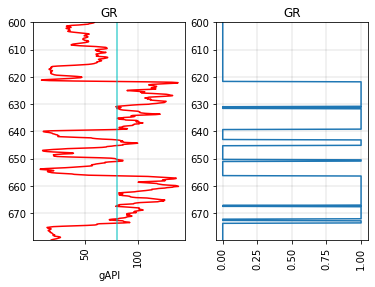

In [41]:
fig, axs = plt.subplots(ncols=2)

# The original log on the left.
segment.plot(ax=axs[0], c='r')
axs[0].axvline(80, c='c', alpha=0.7)

# Make and plot a blocked version.
segment.block(cutoffs=80).plot(ax=axs[1])
axs[1].set_xlabel('')

Or we can use two cutoffs and get a blocked log with three different values. By default the new values will be 0, 1, 2, but we can assign whatever we like:

<AxesSubplot:title={'center':'GR'}, xlabel='gAPI'>

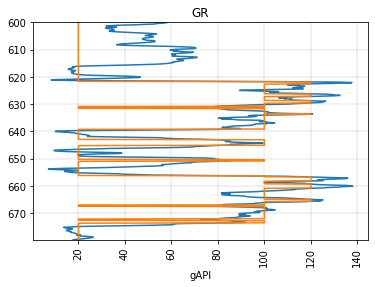

In [45]:
fig, ax = plt.subplots()

segment.plot(ax=ax)
segment.block(cutoffs=(80, 120), values=(20, 100, 120)).plot(ax=ax)

You can send a function in to determine replacement values from the original log. E.g., to replace the values with the block's mean value:

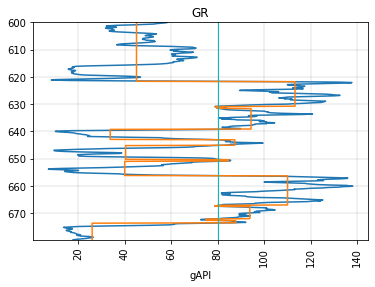

In [46]:
fig, ax = plt.subplots()

segment.plot(ax=ax)
segment.block(cutoffs=80, function=np.mean).plot(ax=ax)
plt.axvline(80, color='c', lw=1)

## Instantiating a new curve

Let's add a curve from a list of values (`data`) with depths (`basis`):

In [47]:
from welly import Curve

params = {'mnemonic': 'FOO', 'run':0, }
data = [20, 30, 40, 20, 10, 0, 10]
c = Curve(data, index=[2,3,4,5,6,7,8], **params)

<AxesSubplot:title={'center':'FOO'}>

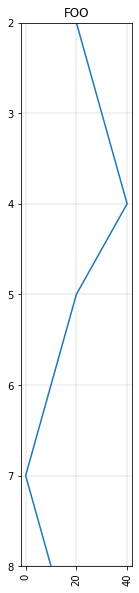

In [48]:
c.plot()

---

&copy; 2022 Agile Scientific, CC BY